In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=128, shuffle=True
)

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=3):  # Keeping latent_dim=2 for visualization
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)  # Mean (μ)
        self.fc_logvar = nn.Linear(400, latent_dim)  # Log variance (log(σ²))
        
        # Decoder
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 28*28)

    def encode(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # z = μ + σ * ε

    def decode(self, z):
        x = F.relu(self.fc2(z))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid to keep values between 0 and 1
        return x

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
def vae_loss(recon_x, x, mu, logvar):
    # Standard VAE Loss with BCE + KL Divergence
    recon_loss = F.binary_cross_entropy(recon_x, x.view(recon_x.shape), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

def loss_without_recon(recon_x, x, mu, logvar):
    # Only KL Divergence loss (removing reconstruction loss)
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def loss_without_kl(recon_x, x, mu, logvar):
    # Only Reconstruction Loss (removing KL Divergence)
    return F.binary_cross_entropy(recon_x, x.view(recon_x.shape), reduction='sum')

def loss_mse(recon_x, x, mu, logvar):
    # Using MSE instead of BCE
    recon_loss = F.mse_loss(recon_x, x.view(recon_x.shape), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [5]:
def train_vae(loss_function, epochs=10, latent_dim=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae = VAE(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)
    
    vae.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch, (images, _) in enumerate(train_loader):
            images = images.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = vae(images)
            loss = loss_function(recon, images, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
    
    return vae

# Function to visualize latent space
def visualize_latent_space(vae):
    vae.eval()
    device = next(vae.parameters()).device
    mu_list, labels_list = [], []
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            _, mu, _ = vae(images)
            mu_list.append(mu.cpu().numpy())
            labels_list.append(labels.numpy())
    mu_list = np.concatenate(mu_list, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    plt.figure(figsize=(8,6))
    plt.scatter(mu_list[:, 0], mu_list[:, 1], c=labels_list, cmap='tab10', alpha=0.5)
    plt.colorbar(label="Digit Label")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space of Means (μ)")
    plt.show()

Training VAE with BCE + KL Divergence Loss
Epoch 1, Loss: 24207.4282
Epoch 2, Loss: 21593.7630
Epoch 3, Loss: 21072.4145
Epoch 4, Loss: 20757.8117
Epoch 5, Loss: 20551.3409
Epoch 6, Loss: 20373.7442
Epoch 7, Loss: 20251.4635
Epoch 8, Loss: 20134.7351
Epoch 9, Loss: 20029.7485
Epoch 10, Loss: 19948.2130


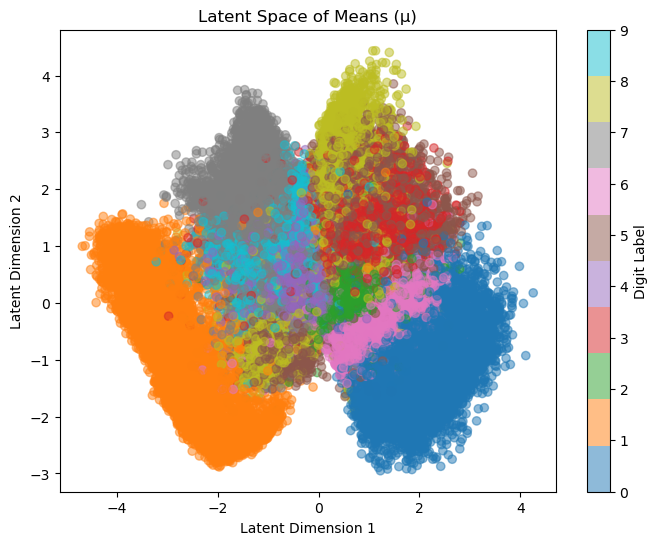

In [6]:
# 1. Train standard VAE with BCE + KL divergence and visualize
print("Training VAE with BCE + KL Divergence Loss")
vae = train_vae(vae_loss)
visualize_latent_space(vae)

Training VAE without Reconstruction Loss
Epoch 1, Loss: 0.0882
Epoch 2, Loss: 0.0013
Epoch 3, Loss: 0.0004
Epoch 4, Loss: 0.0001
Epoch 5, Loss: 0.0001
Epoch 6, Loss: 0.0000
Epoch 7, Loss: 0.0000
Epoch 8, Loss: 0.0000
Epoch 9, Loss: 0.0000
Epoch 10, Loss: 0.0000


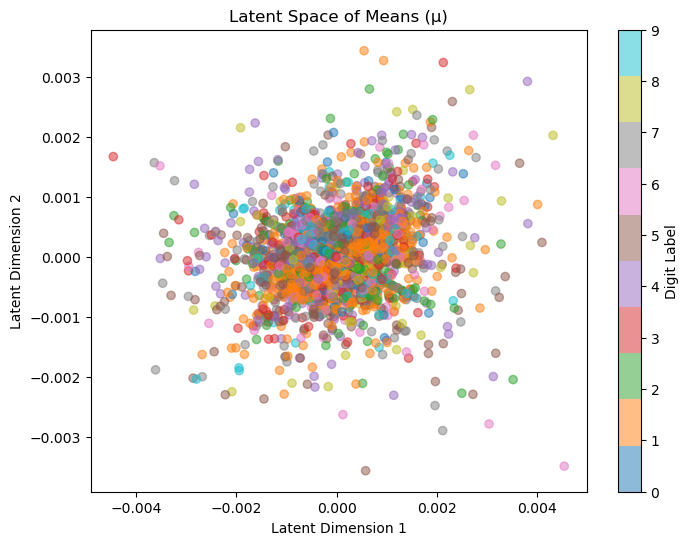

In [7]:
# 2. Train VAE without reconstruction loss
print("Training VAE without Reconstruction Loss")
vae_no_recon = train_vae(loss_without_recon)
visualize_latent_space(vae_no_recon)

Training VAE without KL Divergence Loss
Epoch 1, Loss: 23403.8451
Epoch 2, Loss: 20710.0447
Epoch 3, Loss: 20100.7495
Epoch 4, Loss: 19727.4474
Epoch 5, Loss: 19470.6066
Epoch 6, Loss: 19268.2529
Epoch 7, Loss: 19114.8329
Epoch 8, Loss: 18992.3775
Epoch 9, Loss: 18886.6170
Epoch 10, Loss: 18791.9087


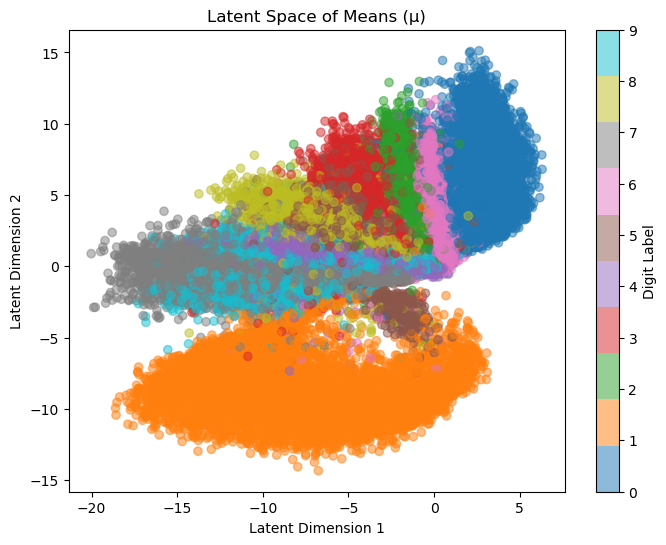

In [8]:
# 3. Train VAE without KL divergence loss
print("Training VAE without KL Divergence Loss")
vae_no_kl = train_vae(loss_without_kl)
visualize_latent_space(vae_no_kl)

Interpretation of Latent Space Visualization with and without KL Divergence:
With KL Divergence (First Image):
The latent space is more compact and continuous, with clusters of different digit classes overlapping smoothly.
The KL divergence regularizes the latent space by enforcing a prior distribution (usually a Gaussian), encouraging the representations to be distributed more uniformly.
The structure appears more rounded and balanced, indicating that the latent space follows a well-defined distribution.
This ensures better generalization, as interpolation between latent points results in meaningful outputs.
Without KL Divergence (Second Image):
The latent space is highly spread out, with clusters pushed to extreme regions.
The representations are highly entangled and stretched, losing the smooth interpolation property.
Some digit classes are concentrated far away from the center, suggesting overfitting or lack of regularization.
Without KL divergence, the latent space lacks a strong constraint, leading to less meaningful sampling and generation.
Importance of KL Divergence:
Encourages Continuity: Ensures that small variations in the latent space result in small variations in output, leading to smoother interpolations.
Prevents Overfitting: Regularizes the encoder to avoid encoding arbitrarily distant points for similar inputs.
Ensures Latent Space Consistency: Helps maintain a structured, Gaussian-like distribution, making the VAE more effective in generating meaningful samples.
Improves Interpolation and Generation: Helps in sampling new points that remain realistic and similar to training data.
Conclusion:
Using KL divergence leads to a more structured and meaningful latent space, improving generalization and sample quality. Without it, the VAE acts more like a regular autoencoder, losing the key benefits of a variational representation.

In [9]:
def visualize_vae_samples(vae, title):
    vae.eval()
    device = next(vae.parameters()).device

    # Structured 2D Gaussian Grid for sampling
    grid_x = np.linspace(-3, 3, 10)  # 10 values along x-axis
    grid_y = np.linspace(-3, 3, 10)  # 10 values along y-axis
    z_samples = np.array([[x, y] for x in grid_x for y in grid_y])  # 100 points

    # Convert to tensor and move to device
    z_samples = torch.tensor(z_samples, dtype=torch.float32).to(device)

    # Generate reconstructed images
    with torch.no_grad():
        recon_images = vae.decode(z_samples).cpu().numpy()

    # Plot the generated images in a 10x10 grid
    plt.figure(figsize=(10, 10))
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        plt.imshow(recon_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

Generating samples from a 2D Gaussian Grid


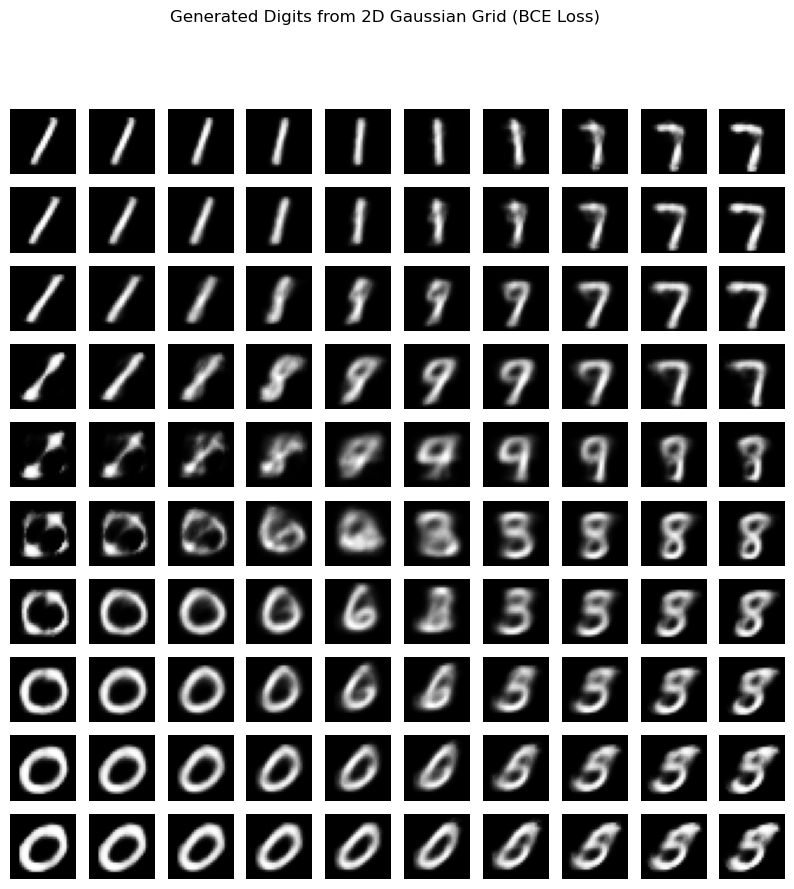

In [10]:
# 4. Generate samples from a 2D Gaussian Grid using BCE-trained VAE
print("Generating samples from a 2D Gaussian Grid")
visualize_vae_samples(vae, "Generated Digits from 2D Gaussian Grid (BCE Loss)")

Training VAE with MSE Loss
Epoch 1, Loss: 6213.3234
Epoch 2, Loss: 5398.0459
Epoch 3, Loss: 5246.2244
Epoch 4, Loss: 5154.5431
Epoch 5, Loss: 5093.2560
Epoch 6, Loss: 5051.7477
Epoch 7, Loss: 5014.8665
Epoch 8, Loss: 4982.2279
Epoch 9, Loss: 4955.2652
Epoch 10, Loss: 4934.6953


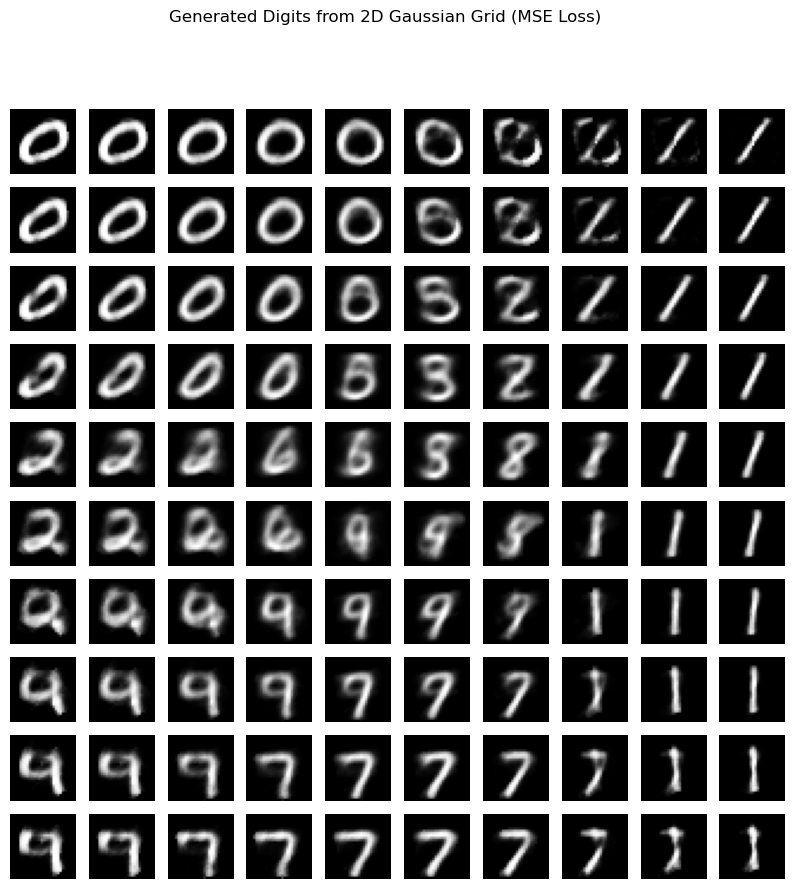

In [11]:
# 5. Train VAE with MSE instead of BCE and visualize grid
print("Training VAE with MSE Loss")
vae_mse = train_vae(loss_mse)
visualize_vae_samples(vae_mse, "Generated Digits from 2D Gaussian Grid (MSE Loss)")

When both Reconstruction loss and KL divergence are used : 

1. The latent space is smooth and continuous and similar points are grouped together, all are centered around 0.

When removing the reconstruction loss:

1. Without reconstruction loss, the latent space became scattered or less structured.
2. There is no ordered clustering, the points are just scattered randomly in space and the loss values became zero

When removing the KL divergence loss:

1. The latent space is poorly structured, the clusters are not centered around 0, they are diverged a lot from zero i.e there are lot of points very far from zero.
2. KL Divergence Loss: Ensures the latent space remains smooth and generalizes well for generation.

Latent Space Visualization :

With BCE : The generated images resemble the MNIST digits and the transition is smooth between different digits

With MSE : The latent space is less structured. Slightly blurrier than with binary cross-entropy, as MSE doesn’t model probabilities. It is less sharp compared to the binary cross-entropy case, with the model potentially losing its generative ability.

